In [7]:
import numpy as np
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.signal import argrelextrema

Main motive of this notes: I was busy playing with Backtrader, trying to implement a succesfull MA cross-over strategy when I wondered, is it actually true that cross-over points can be seen of precursor of positive and negative trends? An also, what is the mathematical definition of a cross-over? It is qualitatively clear but not very defined quantitatively: for example how far should the MAs have been before a cross-over in order to consider it a signal for a trend? Or what should be the influence of the cross-over slope (the angle at which the two MAs touch) on our decision process?
 

I decided to try to experimenting with some historical data from the DOW 30 Index

In [2]:
ph=pd.read_csv('./data_examples/01_2016_US30_USD.M1.csv')
ph.head()

,date,time,open,max,min,close,volume
0,2016-01-01,22:46:00,17393.7,17393.7,17393.7,17393.7,1
1,2016-01-03,22:00:00,17408.4,17408.4,17408.4,17408.4,1
2,2016-01-03,22:33:00,17417.0,17417.0,17408.4,17408.4,2
3,2016-01-03,22:45:00,17417.0,17417.0,17417.0,17417.0,1
4,2016-01-03,22:50:00,17413.9,17413.9,17413.9,17413.9,1


Conversion of the time stamp from string to a Unix time

In [3]:
b=ph.as_matrix()
price=np.zeros((b.shape[0],6))
for i in range(b.shape[0]):
    dt=datetime.strptime(b[i,0]+' '+b[i,1], '%Y-%m-%d %H:%M:%S')
    price[i,0]=time.mktime(dt.timetuple())
    price[i,1:]=b[i,2:]

My main idea was to use a k-Nearest Neightbor method to perform a quantitative analysis of the MA cross-over properties.

The idea is to use a "similarity" function to detect the cross-over points between two moving averages within our historical data.

This is done by:
    
- Computing two moving averages of the price (defined respectively by the MA_period1 and MA_period2 arguments),
- Calculating their difference
- Use a sliding window to measure the similarity between the local value of such difference and a reference linear function. This similarity can be defined by using a standard cosine similarity. 
- Once we collected this similarity measure over time we can search for the values which are as close as possible to 1 (because we used a cosine similarity)
- These points should represent the moments were the two moving average crossed with a speed and a slope defined by the reference similarity function. (in this case defined using numpy.linspace())


In [4]:
def similarity(MA_period1,MA_period2,window_size):

    mov_av=np.ones((MA_period1,))/MA_period1 #np.arange(0,MA_period)/MA_period**2*2.0 #
    MA1=np.convolve(price[:,4], mov_av, mode='valid')
    MA1=np.hstack((np.zeros(MA_period1-1),MA1))

    mov_av=np.ones((MA_period2,))/MA_period2 #np.arange(0,MA_period)/MA_period**2*2.0 #
    MA2=np.convolve(price[:,4], mov_av, mode='valid')
    MA2=np.hstack((np.zeros(MA_period2-1),MA2))
    reference=np.linspace(1,-1,window_size)
    dMA=MA2-MA1
    r=np.zeros(MA1.shape)-1e4
    ref_norm=LA.norm(reference)
    for i in range(max(MA_period1,MA_period2),len(dMA)-window_size):
        r[i]=np.dot(reference,dMA[i-window_size/2:i+window_size/2])/(ref_norm*LA.norm(dMA[i-window_size/2:i+window_size/2]))
#        r[i]=np.dot(reference-dMA[i-window_size/2:i+window_size/2],reference-dMA[i-window_size/2:i+window_size/2])
    return MA1,MA2,r

Let's try to find the cross over points between the 10 min MA and the 30 min one, looking for a cross-over time of 50 minutes

In [12]:
MA1,MA2,r=similarity(10,30,50)

r contains the value of the similarity function over time. We can sort this vector to find the clearest cross-over points (when using a cosine similarity we are looking for values as close as possible to 1). Let's say we want to find the k=20 best cross-over instances over the historical data 

In [18]:
k=20
i=argrelextrema(r, np.greater)
w=r[i]
i2=np.argsort(w)[-k:] 
i3=i[0][i2]
#i=np.argsort(r)[-k:]
#i=np.sort(i)
#print np.sort(i)
#i[[0,4,8,10,12,14]]=0

Let's check whether the most similar point is actually a cross-over points

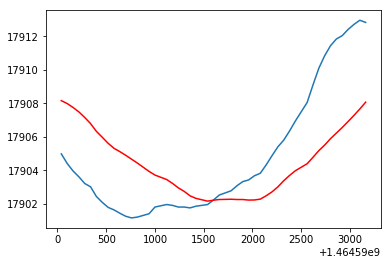

In [20]:
plt.plot(price[i3[0]-25:i3[0]+25,0],MA1[i3[0]-25:i3[0]+25])
plt.plot(price[i3[0]-25:i3[0]+25,0],MA2[i3[0]-25:i3[0]+25],'red')

Bingo! What about the 20th most similar point?

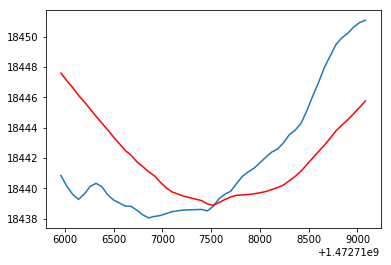

In [22]:
plt.plot(price[i3[19]-25:i3[19]+25,0],MA1[i3[19]-25:i3[19]+25])
plt.plot(price[i3[19]-25:i3[19]+25,0],MA2[i3[19]-25:i3[19]+25],'red')

Noice! Now let's see how the price behaved after the 20 MA cross-over points we've just found

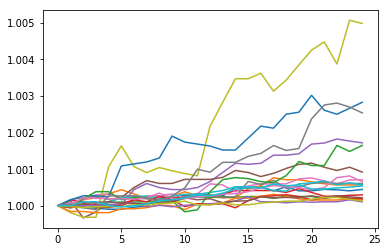

In [23]:
for j in range(len(i3)):
    plt.plot(price[i3[j]:i3[j]+25,4]/price[i3[j],4])



Well, we can clearly see a positive trend! Now the question is: can we take advantage of this information in an algorithmic fashion? In principle a statistical analysis of these sets of similar points could lead us to recommendations about the probability of a positive trend given a certain type of cross-over plus some additional information about the optimal values for Stop Loss and Take Profit orders...

furthermore we could adopt a similar measure within the trading algorithm itself therefore introducing more clarity about the definition of cross-over.

More to follow!